# Generative Adversarial Networks

This notebook implements a very basic GAN with MLPs for the 2 networks.

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
mnist = input_data.read_data_sets("MNIST_data/")
images = mnist.train.images

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Weight initialisation

The weights will be initiliased using the Xavier initialisation method [1]. In this case, this is just a Gaussian distribution with a custom standard deviation: the standard deviation is inversely proportional to the number of neurons feeding into the neuron.

$$ \mathbf{w}_i \sim \mathcal{N}(0, \frac{1}{n_{i-1}}) $$

where $n_{i-1}$ is the number of inputs that feed into the current neuron.

I also tried with regular Gaussian (i.e. constant $\sigma$) and with uniform distribution, but I did not manage to get the network learning.

[1] *Glorot, Xavier, and Yoshua Bengio. "Understanding the difficulty of training deep feedforward neural networks." Aistats. Vol. 9. 2010.*

In [3]:
def xavier_initializer(shape):
    return tf.random_normal(shape=shape, stddev=1/shape[0])

## Architecture

In [4]:
# Generator
z_size = 100 # Latent vector dimension
g_w1_size = 400 
g_out_size = 28 * 28

# Discriminator
x_size = 28 * 28
d_w1_size = 400
d_out_size = 1

In [5]:
z = tf.placeholder('float', shape=(None, z_size))
X = tf.placeholder('float', shape=(None, x_size))

## Weights

In [6]:
g_weights = {
    'w1': tf.Variable(xavier_initializer(shape=(z_size, g_w1_size))),
    'b1': tf.Variable(tf.zeros(shape=[g_w1_size])),
    'out': tf.Variable(xavier_initializer(shape=(g_w1_size, g_out_size))),
    'b2': tf.Variable(tf.zeros(shape=[g_out_size])),
}

d_weights ={
    'w1': tf.Variable(xavier_initializer(shape=(x_size, d_w1_size))),
    'b1': tf.Variable(tf.zeros(shape=[d_w1_size])),
    'out': tf.Variable(xavier_initializer(shape=(d_w1_size, d_out_size))),
    'b2': tf.Variable(tf.zeros(shape=[d_out_size])),
}

## Models

The models were chosen to be very simple, so just an MLP with 1 hidden layer and 1 output layer.

In [7]:
def G(z, w=g_weights):
    h1 = tf.nn.relu(tf.matmul(z, w['w1']) + w['b1'])
    return tf.sigmoid(tf.matmul(h1, w['out']) + w['b2'])

def D(x, w=d_weights):
    h1 = tf.nn.relu(tf.matmul(x, w['w1']) + w['b1'])
    return tf.sigmoid(tf.matmul(h1, w['out']) + w['b2'])

## Latent distribution

This function generates a prior for G.

In [8]:
def generate_z(n=1):
    return np.random.normal(size=(n, z_size))

In [9]:
sample = G(z) # To be called during session

## Cost

The cost functions are the ones used in the original GAN paper [2], using the suggestion of switching the loss for G from minimising $\frac{1}{m}\sum_{i=1}^m(1-D(G(\mathbf{z}))$ to maximising $\frac{1}{m}\sum_{i=1}^m(D(G(\mathbf{z}))$.

Note that because both need to be maximised, and TF is designed to minimise, we take the negative values below.


[2] *Goodfellow, Ian, et al. "Generative adversarial nets." Advances in neural information processing systems. 2014.*


In [10]:
G_objective = -tf.reduce_mean(tf.log(D(G(z))))
D_objective = -tf.reduce_mean(tf.log(D(X)) + tf.log(1 - D(G(z))))

## Optimisation

Note that each of the optimiser takes a `var_list` argument to only consider the variables provided. This is because we don't want D to train G when D is trained, but rather freeze the weights from G and only concern about D (and the same for G).

In [11]:
G_opt = tf.train.AdamOptimizer().minimize(
    G_objective, var_list=g_weights.values())
D_opt = tf.train.AdamOptimizer().minimize(
    D_objective, var_list=d_weights.values())

## Training

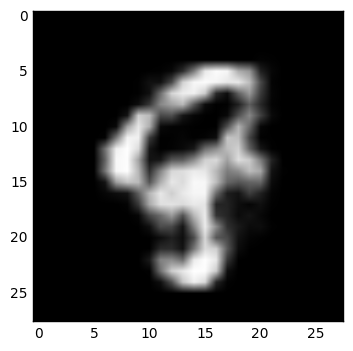

In [13]:
# Hyper-parameters
epochs = 50000
batch_size = 128

# Session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for _ in range(epochs):
        sess.run(G_opt, feed_dict={
            z: generate_z(batch_size)            
        })
        sess.run(D_opt, feed_dict={
            X: images[np.random.choice(range(len(images)), batch_size)].reshape(batch_size, x_size),
            z: generate_z(batch_size),
        })

    # Show a random image
    image = sess.run(sample, feed_dict={z:generate_z()})
    plt.imshow(image.reshape(28, 28), cmap='gray')